In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
%matplotlib inline

In [4]:
class TimeseriesData():
    def __init__(self, num_points, x_min, x_max):
        
        assert x_min < x_max, 'x_min should be smaller than x_max'
        assert num_points > 0, 'number of points in a given range should be greater than zero!'
        
        self.num_points = num_points
        self.x_min = x_min
        self.x_max = x_max
        self.resolution = (x_max - x_min) / num_points
        self.x_data = np.linspace(x_min, x_max, num_points)
        self.y_true = np.sin(self.x_data)
    
    @staticmethod    
    def return_true(x_series):
        return np.sin(x_series)
    
    def next_batch(self, batch_size, steps, return_batch_ts=False):
        rand_start = np.random.rand(batch_size, 1)
        # convert on time series
        ts_start = rand_start * (self.x_max - self.x_min - steps*self.resolution)
        # create batch
        ts_batch = ts_start + np.arange(0.0, steps + 1) * self.resolution
        
        y_batch = self.return_true(ts_batch)
        
        if return_batch_ts:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1), ts_batch
        else:
            return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)
        

In [5]:
data = TimeseriesData(250, 0, 10)

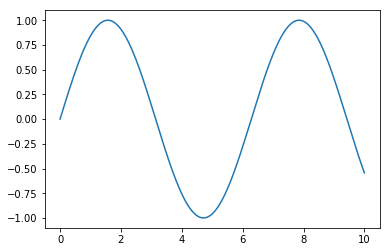

In [7]:
plt.plot(data.x_data, data.y_true)

In [8]:
num_time_steps = 30

In [15]:
y1, y2, ts = data.next_batch(1, num_time_steps, True)

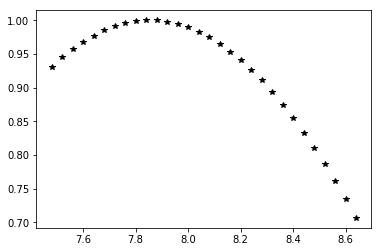

In [16]:
plt.plot(ts.flatten()[1:], y2.flatten(), 'k*')

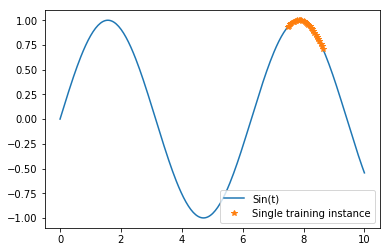

In [17]:
plt.plot(data.x_data, data.y_true, label='Sin(t)')
plt.plot(ts.flatten()[1:], y2.flatten(), '*', label='Single training instance')
plt.legend()

# Create the Model

In [18]:
tf.reset_default_graph()

In [49]:
num_inputs = 1
num_neurons = 100
num_outputs = 1
learning_rate = 0.0001
num_train_iters = 3000
batch_size = 1

In [21]:
# placeholders
x = tf.placeholder(tf.float32, [None, num_time_steps, num_inputs])
y = tf.placeholder(tf.float32, [None, num_time_steps, num_outputs])

In [50]:
# RNN cell layer
cell = tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.relu)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=num_outputs)

In [51]:
outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

ValueError: Variable rnn/output_projection_wrapper/kernel already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/usr/local/lib/python3.6/site-packages/tensorflow/contrib/rnn/python/ops/core_rnn_cell.py", line 227, in call
    projected = _linear(output, self._output_size, True)
  File "<ipython-input-23-266cf76927e0>", line 1, in <module>
    outputs, states = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)
  File "/usr/local/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
# MSE
loss = tf.reduce_mean(tf.square(outputs - y))

In [42]:
# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

In [43]:
init = tf.global_variables_initializer()

In [44]:
saver = tf.train.Saver()

In [52]:
with tf.Session() as sess:
    sess.run(init)
    
    for iter in range(num_train_iters+1):
        batch_input, batch_target = data.next_batch(batch_size, num_time_steps)
        sess.run(train, feed_dict={
            x: batch_input,
            y: batch_target
        })
        
        if iter % 100 == 0:
            mse = loss.eval(feed_dict={
                x: batch_input,
                y: batch_target
            })
            print('Iteration: {}, MSE: {}'.format(iter, mse))
            
    saver.save(sess, './rnn_model_timeseries_GRU')
        

Iteration: 0, MSE: 0.11494677513837814
Iteration: 100, MSE: 0.21901988983154297
Iteration: 200, MSE: 0.023766720667481422
Iteration: 300, MSE: 0.018393157050013542
Iteration: 400, MSE: 0.005401287693530321
Iteration: 500, MSE: 0.02234572544693947
Iteration: 600, MSE: 0.011410409584641457
Iteration: 700, MSE: 0.023413527756929398
Iteration: 800, MSE: 0.0011901144171133637
Iteration: 900, MSE: 0.0029710649978369474
Iteration: 1000, MSE: 0.004393901210278273
Iteration: 1100, MSE: 0.000517984211910516
Iteration: 1200, MSE: 0.02329428121447563
Iteration: 1300, MSE: 0.0022468504030257463
Iteration: 1400, MSE: 0.014759132638573647
Iteration: 1500, MSE: 0.01141295488923788
Iteration: 1600, MSE: 0.017937157303094864
Iteration: 1700, MSE: 0.008684288710355759
Iteration: 1800, MSE: 0.0026978093665093184
Iteration: 1900, MSE: 0.014514503069221973
Iteration: 2000, MSE: 0.0074067506939172745
Iteration: 2100, MSE: 0.0022191063035279512
Iteration: 2200, MSE: 0.005163693800568581
Iteration: 2300, MSE: 

In [53]:
train_inst = np.linspace(5, 5 + data.resolution*(num_time_steps + 1), num_time_steps + 1)

In [55]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_model_timeseries_GRU')
    new_input = np.sin(np.array(train_inst[:-1].reshape(-1, num_time_steps, num_inputs)))
    y_pred = sess.run(outputs, feed_dict={
        x: new_input
    })

INFO:tensorflow:Restoring parameters from ./rnn_model_timeseries_GRU


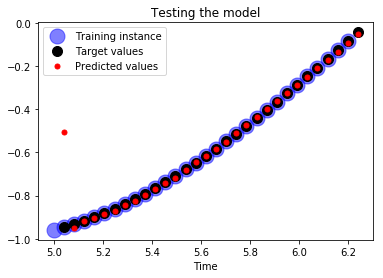

In [56]:
plt.title('Testing the model')
# input values
plt.plot(train_inst[:-1], np.sin(train_inst[:-1]), 'bo', markersize=15, alpha=0.5, label='Training instance')
# target to predict
plt.plot(train_inst[1:], np.sin(train_inst[1:]), 'ko', markersize=10, label='Target values')
# model prediction
plt.plot(train_inst[1:], y_pred[0, :, 0], 'r.', markersize=10, label='Predicted values')
plt.xlabel('Time')
plt.legend()

In [57]:
len(data.x_data)

250

# Generating new sequence

In [58]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_model_timeseries_GRU')
    
    # seed with zeros
    zero_seq_seed = np.zeros(num_time_steps, dtype=np.float32)
    
    for iteration in range(len(data.x_data) - num_time_steps):
        input_batch = zero_seq_seed[-num_time_steps:].reshape(1, num_time_steps, 1)
        predicted_batch = sess.run(outputs, feed_dict={
            x: input_batch
        })
        zero_seq_seed = np.hstack([zero_seq_seed, predicted_batch[0, -1, 0]])

INFO:tensorflow:Restoring parameters from ./rnn_model_timeseries_GRU


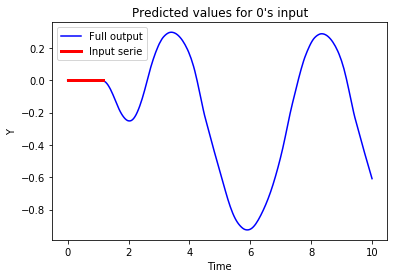

In [59]:
plt.title('Predicted values for 0\'s input')
plt.plot(data.x_data, zero_seq_seed, 'b-', label='Full output')
plt.plot(data.x_data[:num_time_steps], zero_seq_seed[:num_time_steps], 'r', linewidth=3, label='Input serie')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()

In [71]:
with tf.Session() as sess:
    saver.restore(sess, './rnn_model_timeseries_GRU')
    train_inst = data.y_true[:num_time_steps]
    
    for iter in range(len(data.x_data) - num_time_steps):
        input_batch = train_inst[-num_time_steps:].reshape(1, num_time_steps, 1)
        predicted_batch = sess.run(outputs, feed_dict={
            x: input_batch
        })
        train_inst = np.hstack([train_inst, predicted_batch[0, -1, 0]])

INFO:tensorflow:Restoring parameters from ./rnn_model_timeseries_GRU


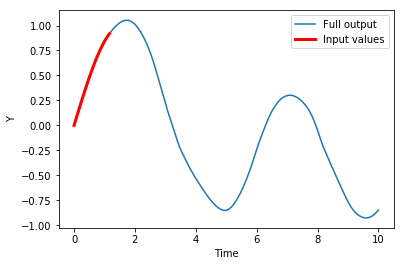

In [72]:
plt.plot(data.x_data, train_inst, label='Full output')
plt.plot(data.x_data[:num_time_steps], train_inst[:num_time_steps], 'r', linewidth=3, label='Input values')
plt.xlabel('Time')
plt.ylabel('Y')
plt.legend()